<a href="https://colab.research.google.com/github/msskx/SiameseNetwork/blob/master/Siamese-networks-medium.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# One Shot Learning with Siamese Networks

This is the jupyter notebook that accompanies

## Imports
All the imports are defined here

In [1]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

## Helper functions
Set of helper functions

In [2]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

## Configuration Class
A simple class to manage configuration

In [3]:
class Config():
    training_dir = "./data/faces/training/"
    testing_dir = "./data/faces/testing/"
    train_batch_size = 64
    train_number_epochs = 100

## Custom Dataset Class
This dataset generates a pair of images. 0 for geniune pair and 1 for imposter pair

In [4]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset ##得到图片路径和对应标签
        self.transform = transform ## 数据增强
        self.should_invert = should_invert ##图像颜色反转为负片
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)## 随机选择一个图片，并得到标签
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) ## 随机确定得到相同或者不同类
        if should_get_same_class: ##如果是相同类
            while True:
                #keep looping till the same class image is found
                #不断循环，直到找到相同的类图像
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                #不断循环，直到找到不同的类图像
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")# 转换为8位像素，黑白
        img1 = img1.convert("L")
        
        if self.should_invert:#如果需要转换就转换为负片
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        # 如果不相同就将 标签置为1，如果相同就将标签置为0
        # 因为计算的是不相似度
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [12]:
folder_dataset = dset.ImageFolder(root=Config.training_dir) ##得到图片路径和对应标签

In [43]:
random.choice(folder_dataset.imgs)

('./data/faces/training/s19/8.pgm', 10)

In [13]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

## Visualising some of the data
The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image.
1 indiciates dissimilar, and 0 indicates similar.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


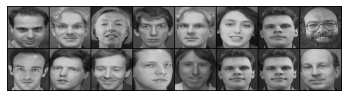

[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]]


In [14]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)
example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [33]:
im=next(dataiter)

In [35]:
im[0].shape

torch.Size([1, 1, 100, 100])

In [36]:
im[1].shape

torch.Size([1, 1, 100, 100])

In [38]:
im[2]

tensor([[0.]])

In [51]:
im

[tensor([[[[0.2000, 0.1922, 0.2039,  ..., 0.2392, 0.2353, 0.2118],
           [0.2039, 0.2000, 0.1961,  ..., 0.2353, 0.2353, 0.2196],
           [0.2000, 0.1922, 0.1961,  ..., 0.2314, 0.2392, 0.2353],
           ...,
           [0.2000, 0.2000, 0.1922,  ..., 0.2431, 0.2353, 0.2510],
           [0.1922, 0.1961, 0.1922,  ..., 0.2471, 0.2275, 0.2392],
           [0.1922, 0.1882, 0.1882,  ..., 0.2392, 0.2392, 0.2275]]]]),
 tensor([[[[0.1882, 0.2000, 0.2000,  ..., 0.2196, 0.2157, 0.1961],
           [0.1922, 0.1882, 0.1961,  ..., 0.2275, 0.2275, 0.2157],
           [0.2000, 0.2000, 0.1843,  ..., 0.2314, 0.2196, 0.2235],
           ...,
           [0.1882, 0.2078, 0.1922,  ..., 0.2078, 0.2039, 0.2157],
           [0.2000, 0.2000, 0.1882,  ..., 0.2118, 0.2000, 0.2196],
           [0.2078, 0.1922, 0.2000,  ..., 0.2196, 0.2157, 0.2157]]]]),
 tensor([[0.]])]

## Neural Net Definition
We will use a standard convolutional neural network

In [15]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output
    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [48]:
from torchsummary import summary

## Contrastive Loss

In [16]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

## Training Time!

In [17]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [19]:
net = SiameseNetwork().cpu()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [59]:
torch.rand((1, 1, 100, 100))

tensor([[[[0.2632, 0.0544, 0.2555,  ..., 0.5219, 0.3786, 0.5888],
          [0.3180, 0.0470, 0.5243,  ..., 0.7331, 0.1413, 0.8288],
          [0.9619, 0.1124, 0.6928,  ..., 0.3498, 0.4082, 0.3742],
          ...,
          [0.3327, 0.7741, 0.1340,  ..., 0.6013, 0.4895, 0.7873],
          [0.8253, 0.5402, 0.6310,  ..., 0.1697, 0.6715, 0.3949],
          [0.4569, 0.6706, 0.1352,  ..., 0.9228, 0.4346, 0.9726]]]])

In [62]:
summary(  net, (torch.rand((1, 1, 100, 100)),torch.rand((1, 1, 100, 100)))  )

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 8, 100, 100]         --
|    └─ReflectionPad2d: 2-1              [-1, 1, 102, 102]         --
|    └─Conv2d: 2-2                       [-1, 4, 100, 100]         40
|    └─ReLU: 2-3                         [-1, 4, 100, 100]         --
|    └─BatchNorm2d: 2-4                  [-1, 4, 100, 100]         8
|    └─ReflectionPad2d: 2-5              [-1, 4, 102, 102]         --
|    └─Conv2d: 2-6                       [-1, 8, 100, 100]         296
|    └─ReLU: 2-7                         [-1, 8, 100, 100]         --
|    └─BatchNorm2d: 2-8                  [-1, 8, 100, 100]         16
|    └─ReflectionPad2d: 2-9              [-1, 8, 102, 102]         --
|    └─Conv2d: 2-10                      [-1, 8, 100, 100]         584
|    └─ReLU: 2-11                        [-1, 8, 100, 100]         --
|    └─BatchNorm2d: 2-12                 [-1, 8, 100, 100]         16
├─Sequential: 

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 8, 100, 100]         --
|    └─ReflectionPad2d: 2-1              [-1, 1, 102, 102]         --
|    └─Conv2d: 2-2                       [-1, 4, 100, 100]         40
|    └─ReLU: 2-3                         [-1, 4, 100, 100]         --
|    └─BatchNorm2d: 2-4                  [-1, 4, 100, 100]         8
|    └─ReflectionPad2d: 2-5              [-1, 4, 102, 102]         --
|    └─Conv2d: 2-6                       [-1, 8, 100, 100]         296
|    └─ReLU: 2-7                         [-1, 8, 100, 100]         --
|    └─BatchNorm2d: 2-8                  [-1, 8, 100, 100]         16
|    └─ReflectionPad2d: 2-9              [-1, 8, 102, 102]         --
|    └─Conv2d: 2-10                      [-1, 8, 100, 100]         584
|    └─ReLU: 2-11                        [-1, 8, 100, 100]         --
|    └─BatchNorm2d: 2-12                 [-1, 8, 100, 100]         16
├─Sequential: 

In [20]:
counter = []
loss_history = [] 
iteration_number= 0

Epoch number 0
 Current loss 1.4058846235275269

Epoch number 1
 Current loss 2.7862002849578857

Epoch number 2
 Current loss 0.7929678559303284

Epoch number 3
 Current loss 0.9126960039138794

Epoch number 4
 Current loss 0.6639912724494934

Epoch number 5
 Current loss 0.6598495841026306

Epoch number 6
 Current loss 0.410990834236145

Epoch number 7
 Current loss 0.47453659772872925

Epoch number 8
 Current loss 0.3080601990222931

Epoch number 9
 Current loss 0.3654099106788635

Epoch number 10
 Current loss 0.18558204174041748

Epoch number 11
 Current loss 0.1638225018978119

Epoch number 12
 Current loss 0.18591409921646118

Epoch number 13
 Current loss 0.16846123337745667

Epoch number 14
 Current loss 0.1734829843044281

Epoch number 15
 Current loss 0.09649559110403061

Epoch number 16
 Current loss 0.09010130912065506

Epoch number 17
 Current loss 0.08845637738704681

Epoch number 18
 Current loss 0.08989258855581284

Epoch number 19
 Current loss 0.12708783149719238

Ep

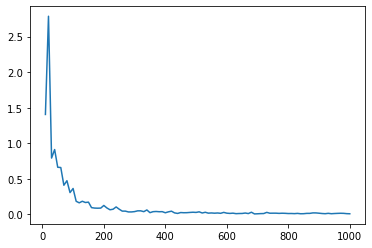

In [23]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cpu(), img1.cpu() , label.cpu()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

## Some simple testing
The last 3 subjects were held out from the training, and will be used to test. The Distance between each image pair denotes the degree of similarity the model found between the two images. Less means it found more similar, while higher values indicate it found them to be dissimilar.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


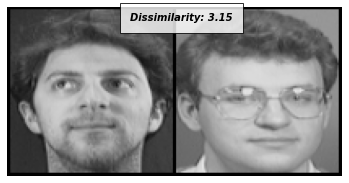

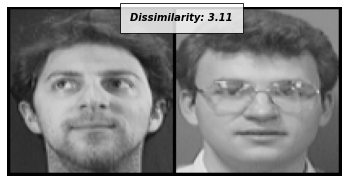

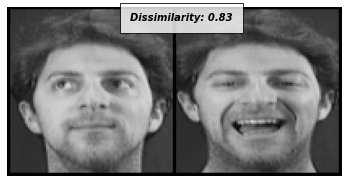

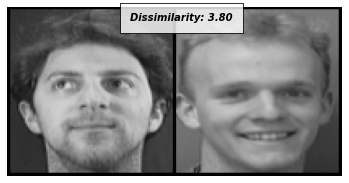

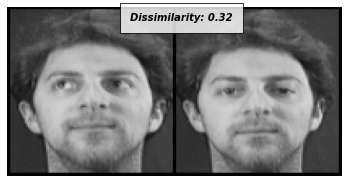

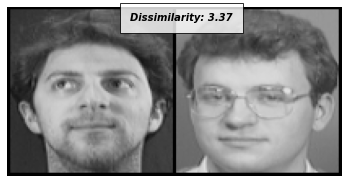

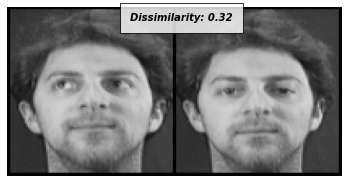

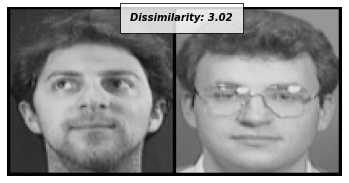

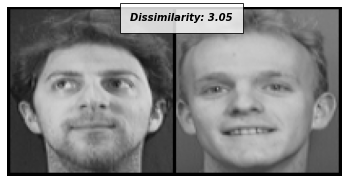

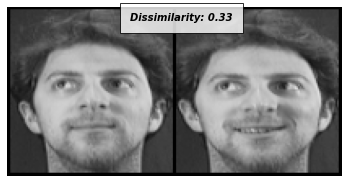

In [25]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cpu(),Variable(x1).cpu())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

